# Spaceship Titanic: 80+% Accuracy

This is a detailed dive into a high-scoring submission I built for Kaggle's Spaceship Titanic Challenge (https://www.kaggle.com/competitions/spaceship-titanic/overview)

The goal is to predict which people survived this fabricated spacechip accident.
The key to a high score is simply to dive deeply into the data and follow the breadcrumbs!

An explanation of the data itself can be found using the above link. 

Now, let's explore how I achieved this result:

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
plt.rcParams["figure.figsize"] = (12, 6)

# Reading + Feature Creation:

In [3]:
titanic_data_train = pd.read_csv("train.csv")
train_size = titanic_data_train.shape[0]
titanic_data_test = pd.read_csv("test.csv")
test_size = titanic_data_test.shape[0]
test_passengerid = titanic_data_test["PassengerId"]

In [4]:
titanic = pd.concat([titanic_data_train, titanic_data_test]).reset_index()

# extracting the group from the id
titanic["PassengerGroup"] = titanic["PassengerId"].str[:4].astype("int64")

# extracting the side and deck from the cabin
titanic["CabinSide"] = titanic["Cabin"].str[-1]
titanic["CabinDeck"] = titanic["Cabin"].str[0]

# creating group_size feature (always >= 1) and InGroup (True if > 1)
group_size = titanic.groupby("PassengerGroup")["PassengerId"].count().sort_index()
titanic["InGroup"] = (group_size.loc[titanic['PassengerGroup']] > 1).reset_index(drop = True)

# brief imputing with 0
titanic[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = titanic[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].fillna(0)

# look at exploration below to see why some are 'good' and others are 'bad'
titanic["GoodAmenities"] = titanic["RoomService"] + titanic["Spa"] + titanic["VRDeck"]
titanic["BadAmenities"] = titanic["FoodCourt"] + titanic["ShoppingMall"]
titanic["Amenities"] = titanic["GoodAmenities"] + titanic["BadAmenities"]

# Error Fixing:

In [5]:
# Some people are supposedly in cryosleep, but spending money on amenities?!
# The average transport rate of those people was ~36%, 
# so I decided they were probably mislabeled as being in cryosleep (where transport rate was ~80%)
titanic.loc[(titanic["CryoSleep"] == True) & (titanic["Amenities"] > 0), "CryoSleep"] = False


# Exploration

In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           12970 non-null  int64  
 1   PassengerId     12970 non-null  object 
 2   HomePlanet      12682 non-null  object 
 3   CryoSleep       12660 non-null  object 
 4   Cabin           12671 non-null  object 
 5   Destination     12696 non-null  object 
 6   Age             12700 non-null  float64
 7   VIP             12674 non-null  object 
 8   RoomService     12970 non-null  float64
 9   FoodCourt       12970 non-null  float64
 10  ShoppingMall    12970 non-null  float64
 11  Spa             12970 non-null  float64
 12  VRDeck          12970 non-null  float64
 13  Name            12676 non-null  object 
 14  Transported     8693 non-null   object 
 15  PassengerGroup  12970 non-null  int64  
 16  CabinSide       12671 non-null  object 
 17  CabinDeck       12671 non-null 

In [7]:
# Notes on each column:

# HomePlanet:
# Seems to have some significance (different transportation rates), 
# but not sure how to fill in 300 null values - maybe try looking at passenger groups 
# (since individuals in the same group probably came from the same planet) to help a little, 
# maybe fill in most popular for the rest

# PassengerGroup:
# Doesn't seem to be too helpful for predicting survival by itself, 
# since groups have a wide range of % transports, but since there are no NULL values,
# it will be useful for figuring out other values like mentioned above

# CryoSleep:
# Highly significant, might be one of the biggest determiners of transportation (for those who chose it)
# again, could we use passenger groups to assume cryosleep status?
# maybe people wouldn't want to be out of cryosleep if their family is in cryosleep, and opposite too.

# Cabin:
# Slight difference in survival rates by CabinSide (Port or Starboard)
# Big differences between 8 different kinds of decks, will probably label encode

# Destination:
# Pretty homogenous as expected, but worth keeping in anyway with label encoding?
# slight differences between homeplanet-endplanet pairs, 
# maybe it's worth making that a set of 3x3 = 9 features?
# i'd say consider replacing both label encoded features with 8 one-hots for each pair
# might be worse who knows

# Age: Kids transported more than adults
# However, a large amount of 0 values makes me think there weren't a bunch of babies on board,
# but rather a NULL equivalent - might want to impute those values too
# for all people below 18, they should be part of a family, right? True... but some still seem legit otherwise,
# except for the really young people

# VIP: 
# pretty simple, slight difference, binary encoding, impute NULL with False (0)
# not kids, usually spend a lot
# one strange thing - why would anyone paying for vip want to be in cryosleep, where they can't experience it?
# is that an error? they don't pay anything for amenities, which means they're probably in cryosleep,
# but they are counted as vip, which might be wrong...?

# All Payments:
# CryoSleep = $0 payments for amenities, most non-asleep have some payments
# !!! After further analysis of different amenities, I believe it is important to separate 
# FoodCourt and Shopping Mall as one feature, and the other three as another, 
# because of how the transport rates change as people spend more money on those 2 vs. the other 3

# Name:
# ...Nothing here
# lots of similar last names (ridiculous ones) from different groups, might be not helpful

#### HomePlanet Analysis:

In [8]:
titanic["HomePlanet"].value_counts()

HomePlanet
Earth     6865
Europa    3133
Mars      2684
Name: count, dtype: int64

In [9]:
titanic.groupby("HomePlanet")["Transported"].mean().sort_values()

HomePlanet
Earth     0.423946
Mars      0.523024
Europa    0.658846
Name: Transported, dtype: object

#### PassengerGroup Analysis:

In [10]:
group_size = titanic.groupby("PassengerGroup")["PassengerId"].count().sort_index()

In [11]:
group_survival = titanic.groupby("PassengerGroup")["Transported"].mean().sort_index()

#### CryoSleep Analysis:

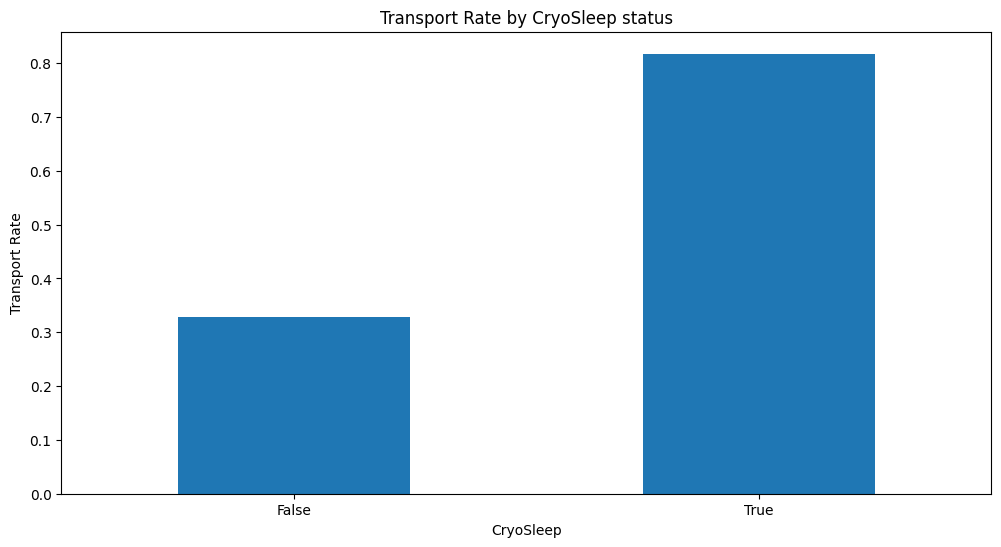

In [23]:
titanic.groupby("CryoSleep")["Transported"].mean().plot(kind = "bar", rot = 0)
plt.title("Transport Rate by CryoSleep status")
plt.ylabel("Transport Rate")
plt.show()

In [34]:
group_cryosleep = titanic.groupby("PassengerGroup")["CryoSleep"].mean().sort_index()[group_size != 1]
group_cryosleep.value_counts()[:3]

CryoSleep
0.5    646
0.0    627
1.0    276
Name: count, dtype: int64

In [282]:
titanic.loc[(titanic["CryoSleep"] == True) & (titanic["Amenities"] > 0)].head()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,VRDeck,Name,Transported,PassengerGroup,CabinSide,CabinDeck,InGroup,GoodAmenities,BadAmenities,Amenities
417,417,0454_01,Europa,True,B/15/S,55 Cancri e,28.0,True,5.0,4288.0,...,5.0,Tabius Geoconne,True,454,S,B,True,755.0,4288.0,5043.0
533,533,0568_01,Europa,True,D/20/S,TRAPPIST-1e,33.0,False,1908.0,33.0,...,4.0,Enibik Baciffhaut,False,568,S,D,True,1913.0,33.0,1946.0
1049,1049,1116_02,Earth,True,NaN,TRAPPIST-1e,36.0,False,0.0,3011.0,...,98.0,Evane Barnolaney,True,1116,S,G,True,98.0,3011.0,3109.0
1764,1764,1874_02,Earth,True,F/374/P,PSO J318.5-22,29.0,False,0.0,0.0,...,1479.0,Vanley Woodgezalez,False,1874,P,F,True,1965.0,0.0,1965.0
1770,1770,1882_01,Europa,True,C/71/S,55 Cancri e,18.0,False,0.0,16263.0,...,15.0,Magnon Antcal,True,1882,S,C,True,15.0,16335.0,16350.0


In [37]:
titanic[(titanic["CryoSleep"] == False) & (titanic["Amenities"] == 0)]

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,VRDeck,Name,Transported,PassengerGroup,CabinSide,CabinDeck,InGroup,GoodAmenities,BadAmenities,Amenities
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,...,0.0,Maham Ofracculy,False,1,P,B,False,0.0,0.0,0.0
19,19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,...,0.0,Lyde Brighttt,True,17,P,G,True,0.0,0.0,0.0
24,24,0020_04,Earth,False,E/0/S,TRAPPIST-1e,10.0,False,0.0,0.0,...,0.0,Breney Jacostanley,True,20,S,E,True,0.0,0.0,0.0
26,26,0020_06,Earth,False,E/0/S,TRAPPIST-1e,7.0,False,0.0,0.0,...,0.0,Terta Mcfaddennon,False,20,S,E,True,0.0,0.0,0.0
34,34,0031_02,Mars,False,F/9/P,TRAPPIST-1e,2.0,False,0.0,0.0,...,0.0,Cinets Datie,True,31,P,F,True,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12805,4112,8933_01,Mars,False,E/572/P,TRAPPIST-1e,22.0,False,0.0,0.0,...,0.0,Terek Brazo,NaN,8933,P,E,False,0.0,0.0,0.0
12818,4125,8960_01,Earth,False,G/1444/S,TRAPPIST-1e,0.0,False,0.0,0.0,...,0.0,Benja Solon,NaN,8960,S,G,True,0.0,0.0,0.0
12824,4131,8971_01,Europa,False,B/290/P,TRAPPIST-1e,46.0,False,0.0,0.0,...,0.0,Betenar Reetholt,NaN,8971,P,B,False,0.0,0.0,0.0
12947,4254,9238_01,Earth,False,G/1501/P,TRAPPIST-1e,10.0,False,0.0,0.0,...,0.0,Joana Garnettiz,NaN,9238,P,G,True,0.0,0.0,0.0


#### Cabin Analysis:

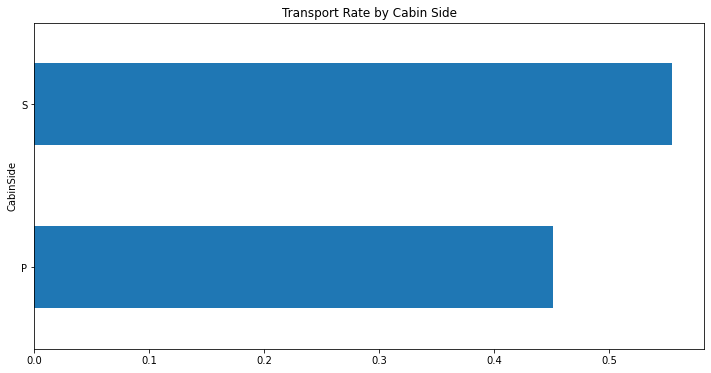

In [149]:
titanic.groupby("CabinSide")["Transported"].mean().plot(kind = "barh")
plt.title("Transport Rate by Cabin Side")
plt.show()

In [155]:
titanic.groupby("CabinDeck")["Transported"].mean().sort_values(ascending = False)

CabinDeck
B    0.734275
C    0.680054
G    0.516217
A    0.496094
F    0.439871
D    0.433054
E    0.357306
T    0.200000
Name: Transported, dtype: float64

#### Destination Analysis:

In [161]:
titanic["Destination"].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [162]:
titanic.groupby("Destination")["Transported"].mean()

Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
Name: Transported, dtype: float64

In [173]:
titanic[titanic["HomePlanet"] == "Earth"].groupby("Destination")["Transported"].mean()

Destination
55 Cancri e      0.504348
PSO J318.5-22    0.498596
TRAPPIST-1e      0.389229
Name: Transported, dtype: float64

In [174]:
titanic[titanic["HomePlanet"] == "Europa"].groupby("Destination")["Transported"].mean()

Destination
55 Cancri e      0.689616
PSO J318.5-22    0.736842
TRAPPIST-1e      0.634987
Name: Transported, dtype: float64

In [175]:
titanic[titanic["HomePlanet"] == "Mars"].groupby("Destination")["Transported"].mean()

Destination
55 Cancri e      0.611399
PSO J318.5-22    0.448980
TRAPPIST-1e      0.511864
Name: Transported, dtype: float64

#### Age Analysis:

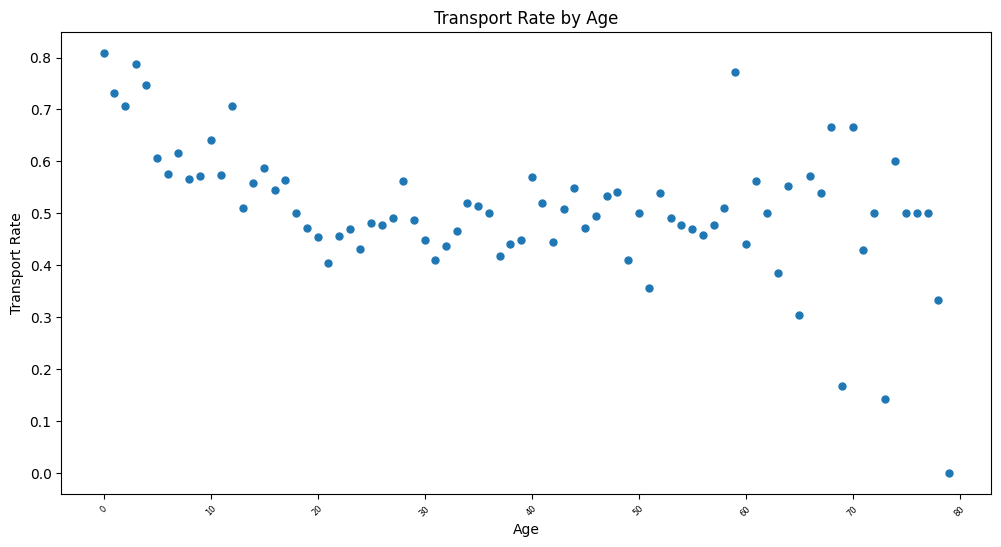

In [88]:
transported_by_age = titanic.groupby("Age")[["Transported"]].mean().reset_index()
transported_by_age.plot(x="Age",y="Transported", kind="scatter", s=25,rot = 45)
plt.ylabel("Transport Rate")
plt.title("Transport Rate by Age")
plt.show()

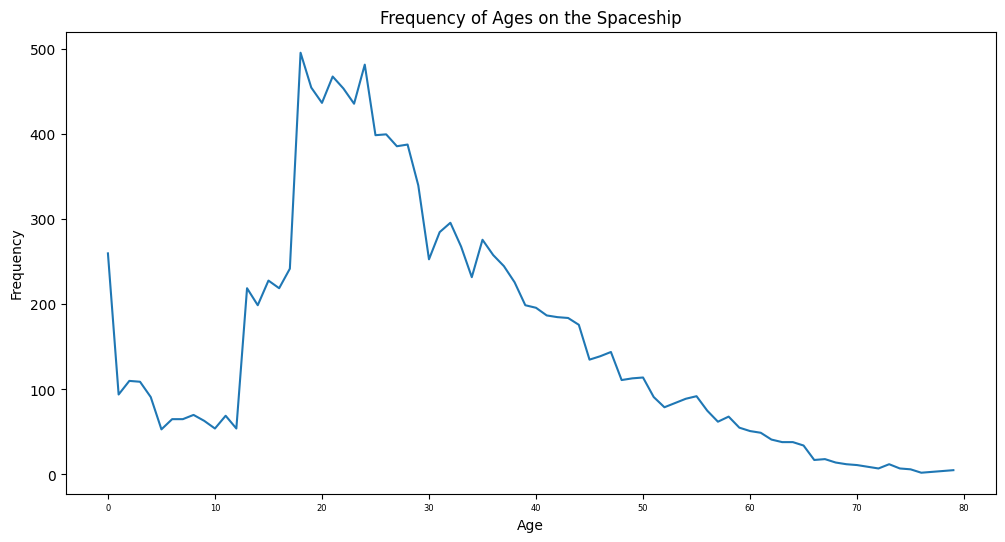

In [87]:
titanic["Age"].value_counts().sort_index().plot()
plt.title("Frequency of All Ages on the Spaceship")
plt.ylabel("Frequency")
plt.show()

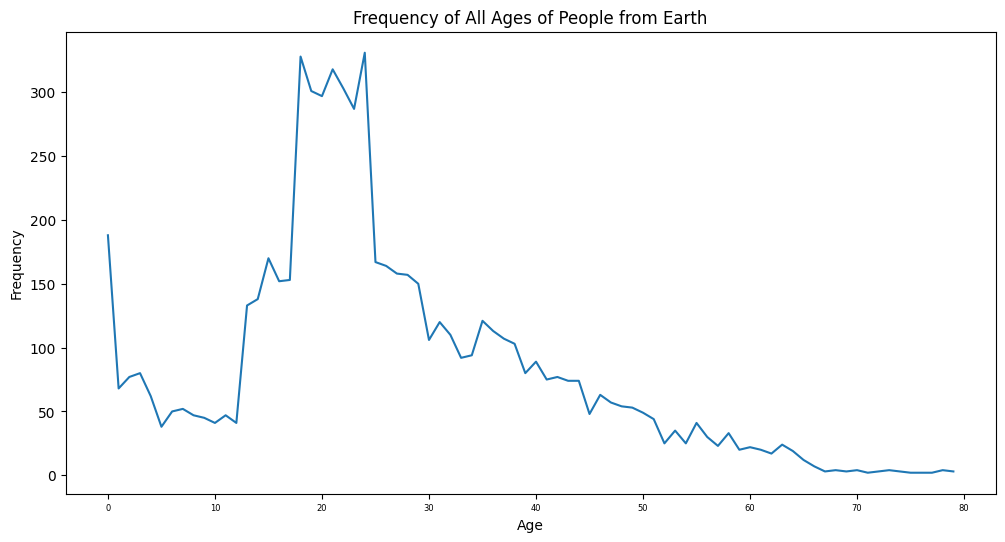

In [90]:
titanic[titanic["HomePlanet"] == "Earth"]["Age"].value_counts().sort_index().plot()
plt.ylabel("Frequency")
plt.title("Frequency of All Ages of People from Earth")
plt.show()

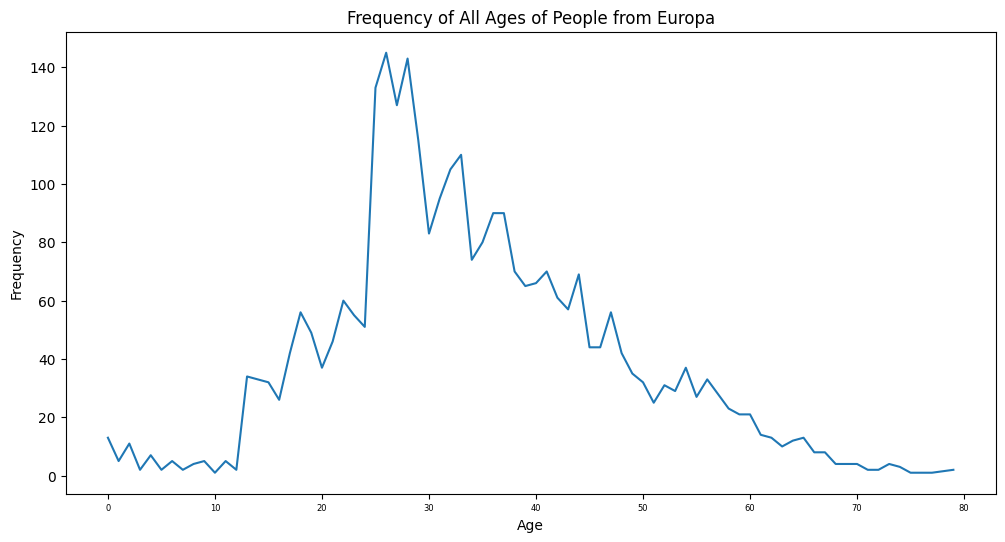

In [91]:
titanic[titanic["HomePlanet"] == "Europa"]["Age"].value_counts().sort_index().plot()
plt.ylabel("Frequency")
plt.title("Frequency of All Ages of People from Europa")
plt.show()

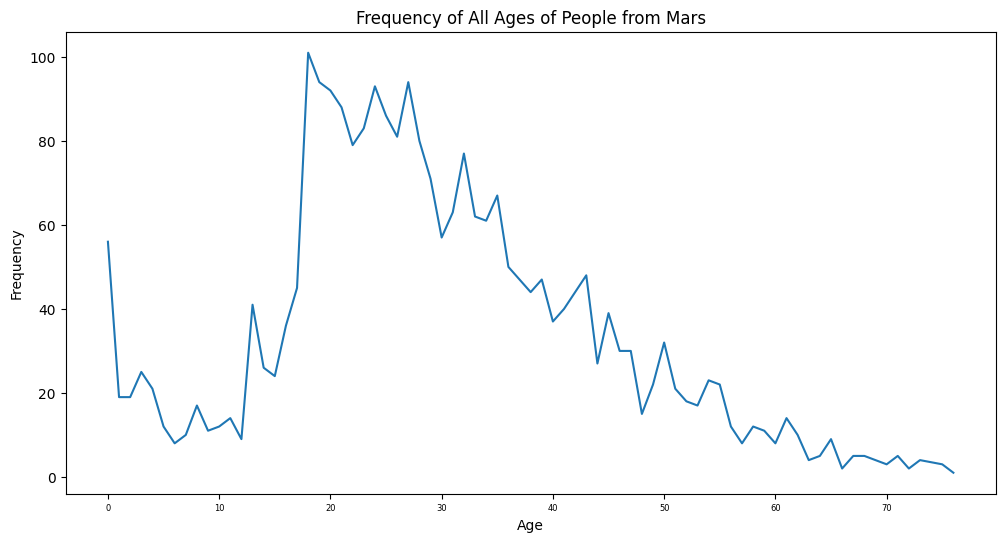

In [92]:
titanic[titanic["HomePlanet"] == "Mars"]["Age"].value_counts().sort_index().plot()
plt.ylabel("Frequency")
plt.title("Frequency of All Ages of People from Mars")
plt.show()

In [395]:
titanic[(titanic["Age"] < 10) & (titanic["InGroup"] == False)]

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,VRDeck,Name,Transported,PassengerGroup,CabinSide,CabinDeck,InGroup,GoodAmenities,BadAmenities,Amenities
308,308,0341_01,Earth,True,G/57/P,PSO J318.5-22,5.0,False,0.0,0.0,...,0.0,Lorian Webstephrey,False,341,P,G,False,0.0,0.0,0.0
585,585,0608_01,Earth,False,G/94/P,TRAPPIST-1e,7.0,False,0.0,0.0,...,0.0,Maril Rilley,True,608,P,G,False,0.0,0.0,0.0
625,625,0650_01,Earth,True,G/95/S,PSO J318.5-22,3.0,False,0.0,0.0,...,0.0,Eulah Hammonton,True,650,S,G,False,0.0,0.0,0.0
748,748,0787_01,Earth,True,G/114/P,TRAPPIST-1e,7.0,False,0.0,0.0,...,0.0,Ritany Quinnerry,False,787,P,G,False,0.0,0.0,0.0
763,763,0802_01,Mars,True,F/148/S,TRAPPIST-1e,1.0,False,0.0,0.0,...,0.0,Plat Pimne,True,802,S,F,False,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12206,3513,7619_01,Earth,True,G/1236/S,TRAPPIST-1e,8.0,False,0.0,0.0,...,0.0,Calvia Reidershley,NaN,7619,S,G,False,0.0,0.0,0.0
12678,3985,8689_01,Earth,True,G/1408/P,TRAPPIST-1e,6.0,False,0.0,0.0,...,0.0,Guye Harrenoldez,NaN,8689,P,G,False,0.0,0.0,0.0
12697,4004,8725_01,Earth,True,G/1405/S,TRAPPIST-1e,7.0,False,0.0,0.0,...,0.0,Antony Barks,NaN,8725,S,G,False,0.0,0.0,0.0
12866,4173,9054_01,Earth,True,G/1458/S,55 Cancri e,8.0,False,0.0,0.0,...,0.0,Coreee Harry,NaN,9054,S,G,False,0.0,0.0,0.0


#### VIP Analysis:

In [ ]:
titanic.groupby("VIP")["Transported"].mean()

VIP
False    0.506332
True     0.381910
Name: Transported, dtype: float64

In [374]:
_vip = titanic[titanic["VIP"] == True]
_vip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 2 to 12865
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           273 non-null    int64  
 1   PassengerId     273 non-null    object 
 2   HomePlanet      267 non-null    object 
 3   CryoSleep       267 non-null    object 
 4   Cabin           266 non-null    object 
 5   Destination     270 non-null    object 
 6   Age             271 non-null    float64
 7   VIP             273 non-null    object 
 8   RoomService     273 non-null    float64
 9   FoodCourt       273 non-null    float64
 10  ShoppingMall    273 non-null    float64
 11  Spa             273 non-null    float64
 12  VRDeck          273 non-null    float64
 13  Name            268 non-null    object 
 14  Transported     199 non-null    object 
 15  PassengerGroup  273 non-null    int64  
 16  CabinSide       266 non-null    object 
 17  CabinDeck       266 non-null    o

In [353]:
_vip["Destination"].value_counts()

TRAPPIST-1e      163
55 Cancri e       85
PSO J318.5-22     22
Name: Destination, dtype: int64

In [355]:
titanic[(titanic["VIP"] == True) & (titanic["Destination"].isnull())]

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,VRDeck,Name,Transported,PassengerGroup,CabinSide,CabinDeck,InGroup,GoodAmenities,BadAmenities,Amenities
4506,4506,4790_01,Europa,False,B/189/S,NaN,54.0,True,0.0,2853.0,...,1666.0,Alarkab Mirinanty,False,4790,S,B,False,1666.0,2853.0,4519.0
8621,8621,9197_02,Europa,False,C/308/P,NaN,41.0,True,0.0,7964.0,...,5839.0,Aludram Platch,False,9197,P,C,True,9077.0,7964.0,17041.0
9892,1199,2529_01,Europa,False,C/89/P,NaN,39.0,True,381.0,1222.0,...,2827.0,Muontak Healist,NaN,2529,P,C,False,3329.0,2326.0,5655.0


In [357]:
_vip["Age"].describe()

count    271.000000
mean      36.664207
std       11.203578
min       18.000000
25%       28.000000
50%       33.000000
75%       42.500000
max       73.000000
Name: Age, dtype: float64

In [360]:
_vip[_vip["CryoSleep"].isnull()]

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,VRDeck,Name,Transported,PassengerGroup,CabinSide,CabinDeck,InGroup,GoodAmenities,BadAmenities,Amenities
417,417,0454_01,Europa,NaN,B/15/S,55 Cancri e,28.0,True,5.0,4288.0,...,5.0,Tabius Geoconne,True,454,S,B,True,755.0,4288.0,5043.0
7933,7933,8470_01,Europa,NaN,C/281/P,55 Cancri e,31.0,True,8243.0,280.0,...,2285.0,Brafirk Aloubtled,False,8470,P,C,False,13748.0,280.0,14028.0
7948,7948,8487_01,Europa,NaN,C/282/P,55 Cancri e,32.0,True,65.0,0.0,...,9811.0,Kajamak Boderbint,False,8487,P,C,False,9964.0,0.0,9964.0
10260,1567,3368_03,Mars,NaN,E/228/S,TRAPPIST-1e,22.0,True,1166.0,3.0,...,0.0,Goats Buko,NaN,3368,S,E,True,1166.0,133.0,1299.0
11018,2325,5053_01,Europa,NaN,A/46/P,TRAPPIST-1e,42.0,True,2.0,722.0,...,368.0,Aludrab Confring,NaN,5053,P,A,False,1405.0,722.0,2127.0
11793,3100,6795_01,Mars,NaN,E/433/P,TRAPPIST-1e,18.0,True,988.0,0.0,...,0.0,Coobix Gecre,NaN,6795,P,E,False,1344.0,732.0,2076.0


In [376]:
titanic[titanic["VIP"] == True]["Amenities"].describe()

count      273.000000
mean      4595.542125
std       5464.818112
min          0.000000
25%       1299.000000
50%       2743.000000
75%       6206.000000
max      33666.000000
Name: Amenities, dtype: float64

In [380]:
titanic[(titanic["VIP"] == False) & (titanic["Amenities"] > 5000)]

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,...,VRDeck,Name,Transported,PassengerGroup,CabinSide,CabinDeck,InGroup,GoodAmenities,BadAmenities,Amenities
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,...,193.0,Solam Susent,False,3,S,A,True,3522.0,1654.0,5176.0
11,11,0008_03,Europa,False,B/1/P,55 Cancri e,45.0,False,39.0,7295.0,...,124.0,Wezena Flatic,True,8,P,B,True,273.0,7884.0,8157.0
30,30,0026_01,Europa,False,C/0/P,55 Cancri e,34.0,False,22.0,6073.0,...,328.0,Anyoni Unconary,False,26,P,C,False,1788.0,6073.0,7861.0
70,70,0074_01,Europa,False,C/3/S,TRAPPIST-1e,42.0,False,1.0,8397.0,...,506.0,Aldibah Mostedry,True,74,S,C,False,507.0,8397.0,8904.0
73,73,0078_01,Europa,False,C/4/S,TRAPPIST-1e,38.0,False,0.0,5840.0,...,9654.0,Spuri Pokerheed,False,78,S,C,False,9975.0,5840.0,15815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12917,4224,9162_02,Europa,False,D/294/P,TRAPPIST-1e,29.0,False,0.0,472.0,...,2650.0,Coxark Ineckethle,NaN,9162,P,D,True,4366.0,910.0,5276.0
12920,4227,9171_01,Europa,False,C/305/P,TRAPPIST-1e,29.0,False,0.0,5718.0,...,5.0,Aliakan Roftfuling,NaN,9171,P,C,False,1449.0,5718.0,7167.0
12930,4237,9206_01,Europa,False,B/352/S,TRAPPIST-1e,27.0,False,0.0,5980.0,...,21.0,Ionan Pokebox,NaN,9206,S,B,True,189.0,5985.0,6174.0
12938,4245,9214_01,Europa,False,C/341/S,TRAPPIST-1e,32.0,False,523.0,2.0,...,14834.0,Alatrix Mirinanty,NaN,9214,S,C,False,15373.0,2.0,15375.0


#### Amenities Analysis:

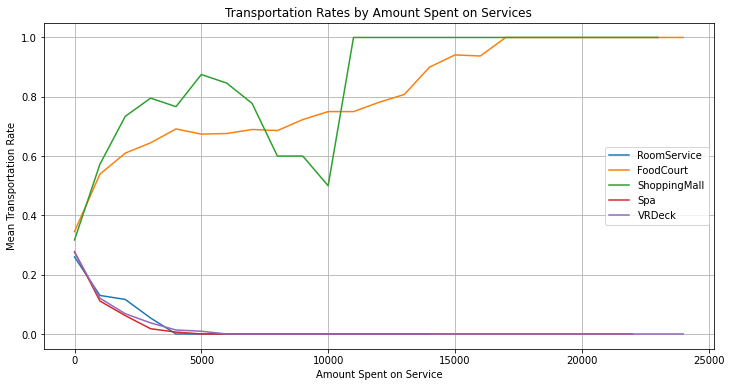

In [240]:
fig, ax = plt.subplots()

categories = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

limits = range(0, 25000, 1000)
transports = []

for cat in categories:
    transports = []
    for limit in limits:
        transport_rate = titanic[titanic[cat] > limit].Transported.mean()
        transports.append(transport_rate)
    plt.plot(limits, transports, label = cat)
plt.legend()
plt.grid()
plt.title("Transportation Rates by Amount Spent on Services")
plt.xlabel("Amount Spent on Service ($)")
plt.ylabel("Mean Transportation Rate")
plt.show()

In [167]:
_room = pd.cut(titanic[cat], bins=500, retbins = True)

titanic[titanic[cat] < 200].hist(cat, bins = 50)

#### Name Analysis(?):

In [8]:
titanic["Name"].str.extract(r'(\w+) (\w+)')

,0,1
0,Maham,Ofracculy
1,Juanna,Vines
2,Altark,Susent
3,Solam,Susent
4,Willy,Santantines
...,...,...
12965,Jeron,Peter
12966,Matty,Scheron
12967,Jayrin,Pore
12968,Kitakan,Conale


# Processing and Cleaning:

## Imputing Nulls:

In [6]:
def impute_common_by_group(titanic, row_index, col_name):
    """
    if someone is a part of a group, impute the most common value in the group.
    else, take most common from the whole training set.
    """
    if titanic.loc[row_index, "InGroup"] == False: #not part of a group
            
        value_counts = titanic[col_name].value_counts()
        most_common = titanic.loc[:train_size, col_name].value_counts().sort_values().index[-1]
        
        #if you want to impute from a probability distribution, use the commented code instead: 
        # cat_values = np.array(value_counts)
        # cat_indices = np.array(value_counts.index)
        # cat_values = cat_values / sum(cat_values)
        # most_common = cat_indices[list(np.random.multinomial(1, cat_values)).index(1)]
        
        titanic.loc[row_index, col_name] = most_common
        
    else:
        group_num = titanic.loc[row_index, "PassengerGroup"]
        group = titanic[titanic["PassengerGroup"] == group_num]
        group_common = group[col_name].value_counts(dropna = False).sort_values()
        if(len(group_common) == 1): #rest of the group is NaN too
            titanic.loc[row_index, col_name] = titanic.loc[:train_size, col_name].value_counts().sort_values().index[-1]
        else:
            
            value_counts = titanic[col_name].value_counts()
            most_common = group[col_name].value_counts().sort_values().index[-1]

            #if you want to impute from a probability distribution, use the commented code instead: 
            # cat_values = np.array(value_counts)
            # cat_indices = np.array(value_counts.index)
            # cat_values = cat_values / sum(cat_values)
            # most_common = cat_indices[list(np.random.multinomial(1, cat_values)).index(1)]

            titanic.loc[row_index, col_name] = most_common
            
def impute_median_by_group(titanic, row_index, col_name):
    """
    if someone is a part of a group, impute the median value in the group.
    else, take median from the whole training set.
    """
    if titanic.loc[row_index, "InGroup"] == False: #not part of a group
        average = titanic.loc[:train_size, col_name].median()
        titanic.loc[row_index, col_name] = average
        
    else:
        group_num = titanic.loc[row_index, "PassengerGroup"]
        group = titanic[titanic["PassengerGroup"] == group_num]
        group_average = [element for element in group[col_name] if not np.isnan(element)]
        if(group_average == []): #rest of group is nan too
            titanic.loc[row_index, col_name] = titanic.loc[:train_size, col_name].median()
        else:
            titanic.loc[row_index, col_name] = group[col_name].median()

#### Current Method of Imputation:

In [7]:
titanic_vips = titanic[titanic["VIP"] == True]

# VIP imputations (most-common and median):
# imputing with other vip's values 
for col in ["HomePlanet", "Destination", "CryoSleep"]:
    for row in list(titanic_vips[titanic_vips[col].isna()].index):
        vip_most_common = titanic_vips[col].value_counts().sort_values().index[-1]
        titanic.loc[row, col] = vip_most_common
for col in ["Age"]:
    for row in list(titanic_vips[titanic_vips[col].isna()].index):
        vip_average = titanic_vips[col].median()
        titanic.loc[row, col] = vip_average        
        
        
#non-VIP most-commons and medians:
for col in ["HomePlanet", "Destination", "VIP", "CabinSide", "CabinDeck"]:
    for row in list(titanic[titanic[col].isna()].index):
        impute_common_by_group(titanic, row, col)
for col in ["CryoSleep"]:
    for row in list(titanic[titanic[col].isna()].index):
        if(titanic.loc[row, "Amenities"] == 0):
            titanic.loc[row, col] = True
        else:
            impute_common_by_group(titanic, row, col)
for col in ["Age"]:
    for row in list(titanic[titanic[col].isna()].index):
        impute_median_by_group(titanic, row, col)

## Dropping, Categorical Encoding, and Scaling: 

In [8]:
#Dropping
titanic_clean = titanic.drop(["Amenities", "PassengerId", "Cabin", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Name", "PassengerGroup"], axis = 1)

In [9]:
#Encoding

cabin_deck_list = ["T", "E", "D", "F", "A", "G", "C", "B"]
# ordle = OrdinalEncoder(categories = cabin_deck_list) #welp, I don't know how this is supposed to work

# manual ordered label:
for col in ["CabinDeck"]:
    for index, item in enumerate(cabin_deck_list):
        titanic_clean.loc[titanic_clean[col] == item, col] = index
        
# label
le = LabelEncoder()
for col in ["CryoSleep", "VIP", "CabinSide", "InGroup"]:
    titanic_clean[col] = le.fit_transform(titanic_clean[col])
    
# labeling everything but nans
for col in ["Transported"]:
    titanic_clean.loc[:train_size, col] = le.fit_transform(titanic_clean.loc[:train_size, col])
    
# #one-hot
for col in ["HomePlanet", "Destination"]:
    titanic_clean = pd.get_dummies(titanic_clean, columns=[col], prefix=[f'{col}_is'], drop_first = True)

In [10]:
#Scaling

for col in ["Age", "GoodAmenities", "BadAmenities"]:
    sc = StandardScaler()
    fitted_scaler = sc.fit(pd.DataFrame(titanic_clean[:train_size][col]))
    titanic_clean[col] = np.squeeze(fitted_scaler.transform(pd.DataFrame(titanic_clean[col])))

In [11]:
# restoring to train and test

train = titanic_clean[:train_size].drop("index", axis = 1)
test = titanic_clean[train_size:].set_index("index").drop("Transported", axis = 1)

# ML Time:

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'xgboost'

## Simple Models:

In [23]:
y = np.array(train["Transported"]).astype(int)
X = np.array(train.drop("Transported", axis = 1))

In [24]:
# you can use cross_val_score, but I did this instead:
def model_predict(clf, X_vals, y_vals):
    skf = KFold(n_splits = 5, shuffle = True)
    final_score = 0
    total_auc = 0
    for train_index, test_index in skf.split(X_vals, y_vals):
        X_train, X_test = X_vals[train_index], X_vals[test_index]
        y_train, y_test = y_vals[train_index], y_vals[test_index]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        final_score += score
        
        exact_preds = clf.predict_proba(X_test)[:,1]
        total_auc += roc_auc_score(y_test, exact_preds)

    print(f"Accuracy Score: {final_score / 5:.1%}")
    print(f"ROC AUC Score: {total_auc / 5}")

### Logistic Regression:

In [25]:
# Naive: 72.7, 0.781
# Smarter: 73.0, 0.785
# Splitting Amenities: 79.1, 0.875
model_predict(LogisticRegression(), X, y)

Accuracy Score: 79.1%
ROC AUC Score: 0.875054829331084


### KNN:

In [26]:
# Naive: 74.1, 0.798
# Smarter: 74.6, 0.804
# Splitting Amenities: 78.7, 0.876
model_predict(KNeighborsClassifier(n_neighbors = 25), X, y)

Accuracy Score: 78.7%
ROC AUC Score: 0.8758501970866291


### Random Forest:

In [27]:
# Naive: 74.3, 0.803
# Smarter: 75.1, 0.811
# Splitting Amenities: 80.7, 0.890
model_predict(RandomForestClassifier(max_depth = 10), X, y)

Accuracy Score: 80.7%
ROC AUC Score: 0.8905448957935984


### Gradient Boosting:

In [28]:
# Naive: 74.3, 0.804
# Smarter: 74.8, 0.811
# Splitting Amenities: 80.3, 0.893
model_predict(GradientBoostingClassifier(n_estimators = 100), X, y)

Accuracy Score: 80.3%
ROC AUC Score: 0.8928416102859865


### Extreme GB:

In [30]:
# Splitting Amenities: 79.9, 0.888
model_predict(XGBClassifier(use_label_encoder = False), X, y)

[10:09:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:09:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:09:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:09:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Cross-val:

In [31]:
cvs = cross_val_score(RandomForestClassifier(), X, y, cv = 5)
cvs.mean()

0.7870721172902698

### General Explanation of Attempts:

 1. Filled everything naively with means and most-commons (should have done medians, but eh)
 2. Added group filling (look at impute_common/median_by_group for details)
 
     2.5. Added ordered label encoding for cabindeck, didn't make much difference
 
 3. Split amenities into two columns for "good" (more spending correlated with lower tranport rate) and "bad"
 
 4. Might try NOT filling every non-group person with total most-common, but instead taking probabilities of each category and randomly choosing from there to preserve the percentages.

## Ensembled/Complex Models:

### Grid Searching for Hyperparameters:

#### Random Forest:

In [632]:
#grid_search for random forest:
params = {'min_samples_split' : [2, 5, 7, 10], 'min_samples_leaf' : [1, 2, 3, 5]}
gcv = GridSearchCV(RandomForestClassifier(n_estimators = 100, max_depth = 10), params, cv = 3, verbose = True)

In [633]:
gcv.fit(X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(max_depth=10),
             param_grid={'min_samples_leaf': [1, 2, 3, 5],
                         'min_samples_split': [2, 5, 7, 10]},
             verbose=True)

In [634]:
print(gcv.best_params_)
print(gcv.best_score_)
print(gcv.best_estimator_)

{'min_samples_leaf': 3, 'min_samples_split': 7}
0.8046718486453744
RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=7)


#### Gradient Boosting:

In [646]:
#grid_search for gradient boosting:
params = {'n_estimators' : [100, 200, 300, 400, 500], 'learning_rate' : [0.0001, 0.001, 0.01, 0.1]}
gcv_gcb = GridSearchCV(GradientBoostingClassifier(), params, cv = 3, verbose = True)

In [647]:
gcv_gcb.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=True)

In [648]:
print(gcv_gcb.best_params_)
print(gcv_gcb.best_score_)
print(gcv_gcb.best_estimator_)

{'learning_rate': 0.1, 'n_estimators': 200}
0.800875730420537
GradientBoostingClassifier(n_estimators=200)


### VotingClassifier:

In [32]:
m1 = RandomForestClassifier(max_depth = 10, min_samples_leaf = 3)
m2 = GradientBoostingClassifier(n_estimators = 200)

vc = VotingClassifier(estimators=[('rfc', m1), ('gb', m2)], voting='soft')
model_predict(vc, X, y)

Accuracy Score: 80.4%
ROC AUC Score: 0.8928830227184269


# Submitting:

In [33]:
train_X = train.drop("Transported", axis = 1)
train_y = train["Transported"].astype(int)

In [34]:
#fitting and predicting 5 times, taking averages and rounding

num_fits = 5
pred_probas = np.array([0.0] * test_size)
for _ in range(num_fits):
    vc.fit(train_X, train_y)
    preds = vc.predict_proba(test)
    array_preds = np.array(preds[:, 1])
    pred_probas += array_preds
    print(pred_probas)
pred_probas /= 5
final_preds = pred_probas.round()

[0.70862094 0.0529179  0.99468133 ... 0.92993239 0.52806153 0.65253634]
[1.41573011 0.101643   1.99226478 ... 1.86835386 1.06806294 1.30795686]
[2.11705208 0.15450077 2.98952913 ... 2.79387764 1.59290598 1.97044617]
[2.81809649 0.21055765 3.98744425 ... 3.7193082  2.15289821 2.59867753]
[3.53010654 0.26501807 4.98521578 ... 4.64922403 2.67966065 3.25907382]


In [35]:
submission = pd.DataFrame()
submission["PassengerId"] = test_passengerid
submission["Transported"] = final_preds.astype("bool")

In [686]:
submission.to_csv("submission2.csv", index = False)

In [36]:
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True
